# Bayesian Hidden Markov Models

Goals - learn transition matrix, emission parameter, and hidden states

In [1]:
# Load libraries.
using Turing, Plots, Random, StatsPlots

# Set a random seed and use the forward_diff AD mode.
Random.seed!(1234);

Sample data - use straightforward states and emission parameters

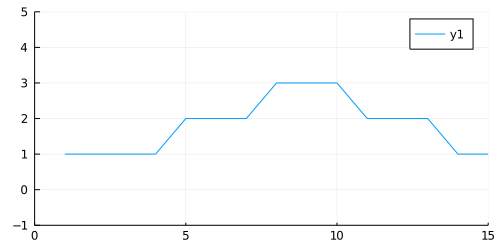

In [2]:
# Define the emission parameter.
y = [ 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0 ];
N = length(y);  
K = 3;

# Plot the data we just made.
plot(y, xlim = (0,15), ylim = (-1,5), size = (500, 250))

This data has 3 states - whant to understand:

1. Transition matrix - probability of switching from one state to another
2. Emission Matrix - typical value emitted by a state (in this case, emission for 1 is 1)
3. State Sequence - what state we're in when observing data. Important when emission value != state

Give a normal distribution on the emission parameter

$$
m_i \sim \text{Normal}(i, 0.5), i={1, 2, 3}
$$

Expect state 1 to emit values in a normally distributed manner, with mean equal to the state value. Variance is limited to 0.5 to help converge quicky - larger would have state 2 emitting 1 and 3 often.

Let priors on transition matrix be noninformative, `T[i] ~ Dirichlet(ones(K)/K)`, which assumes the state will change from one to any other with equal probability.

In [3]:
@model BayesHmm(y, K) = begin
    # Get observation length.
    N = length(y)

    # State sequence.
    s = tzeros(Int, N)

    # Emission matrix.
    m = Vector(undef, K)

    # Transition matrix.
    T = Vector{Vector}(undef, K)

    # Assign distributions to each element
    # of the transition matrix and the
    # emission matrix.
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Normal(i, 0.5)
    end

    # Observe each point of the input.
    s[1] ~ Categorical(K)
    y[1] ~ Normal(m[s[1]], 0.1)

    for i = 2:N
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Normal(m[s[i]], 0.1)
    end
end;
    

Will use both HMC and Particle Gibbs to sample, HMC for `m` and `T`, particle gibbs for `s` (due to it being a categorical variable).

In [4]:
# Sample
g = Gibbs(HMC(0.001, 7, :m, :T), PG(20, :s))
c = sample(BayesHmm(y, 3), g, 500);

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:34


This sample generates a lot of parameters, as we can see, so `describe` isn't ideal.

We'll draw an animation of the data our model generates in each sample.

┌ Info: Saved animation to 
│   fn = /Users/tburch/Documents/github/TuringTutorialsRework/figures/bayeshmm.gif
└ @ Plots /Users/tburch/.julia/packages/Plots/GDtiZ/src/animation.jl:104


Plots.AnimatedGif("/Users/tburch/Documents/github/TuringTutorialsRework/figures/bayeshmm.gif")
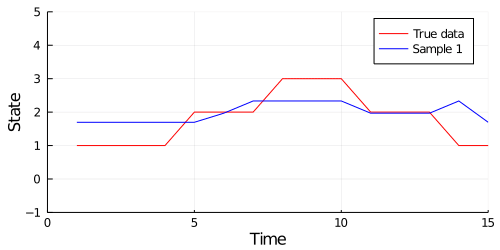

In [5]:

# Extract our m and s parameters from the chain.
m_set = Array(group(c, :m))
s_set = Array(group(c, :s))

# Iterate through the MCMC samples.
Ns = 1:length(c)

# Make an animation.
animation = @animate for i in Ns
    m = m_set[i, :]; 
    s = Int.(s_set[i,:]);
    emissions = collect(skipmissing(m[s]))
    
    p = plot(y, c = :red,
        size = (500, 250),
        xlabel = "Time",
        ylabel = "State",
        legend = :topright, label = "True data",
        xlim = (0,15),
        ylim = (-1,5));
    plot!(emissions, color = :blue, label = "Sample $i")
end every 10;
gif(animation, "figures/bayeshmm.gif", fps=8)

This looks not bad (but not as good as the example). To check convergence, plot the transition matrix over samples, so look at the diagonal

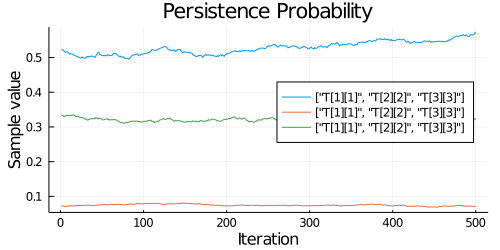

In [6]:
# Index the chain with the persistence probabilities.
subchain = c[:,["T[$i][$i]" for i in 1:K],:]

# Plot the chain.
plot(subchain, 
    colordim = :parameter, 
    seriestype=:traceplot,
    title = "Persistence Probability",
    legend=:right
    )

A little wobbly, not perfect. We can also use diagnostic functions in MCMCChains to formally test, e.g. Heidelberg and Welch diagnostic:

In [7]:
heideldiag(group(c,:T))[1]

Heidelberger and Welch Diagnostic - Chain 1
  parameters     burnin   stationarity    pvalue      mean   halfwidth      test  
      Symbol    Float64        Float64   Float64   Float64     Float64   Float64  
                                                                                  
     T[1][1]   250.0000         0.0000    0.0224    0.5394      0.0137    1.0000  
     T[1][2]   250.0000         0.0000    0.0279    0.1257      0.0110    1.0000  
     T[1][3]   200.0000         1.0000    0.0604    0.3349      0.0025    1.0000  
     T[2][1]     0.0000         1.0000    0.0518    0.0037      0.0003    1.0000  
     T[2][2]   150.0000         1.0000    0.1034    0.0739      0.0013    1.0000  
     T[2][3]   150.0000         1.0000    0.0751    0.9225      0.0015    1.0000  
     T[3][1]     0.0000         1.0000    0.2200    0.4286      0.0053    1.0000  
     T[3][2]     0.0000         1.0000    0.2748    0.2481      0.0026    1.0000  
     T[3][3]   200.0000         1.0000    0